    Country/Region      Lat     Long  1/22/20  ...  5/2/20  5/3/20  5/4/20  5/5/20
225             US  37.0902 -95.7129        0  ...  175382  180152  187180  189791

[1 rows x 108 columns]
    Country/Region      Lat     Long  ...   5/2/20   5/3/20   5/4/20
225             US  37.0902 -95.7129  ...  1132539  1158040  1180375

[1 rows x 107 columns]
    Country/Region      Lat     Long  1/22/20  ...  5/1/20  5/2/20  5/3/20  5/4/20
225             US  37.0902 -95.7129        0  ...   64943   66369   67682   68922

[1 rows x 107 columns]
country=US, beta=0.00000227, gamma=0.06701774, r_0:0.00003390
    Country/Region   Lat  Long  1/22/20  ...  5/2/20  5/3/20  5/4/20  5/5/20
131          Italy  43.0  12.0        0  ...   79914   81654   82879   85231

[1 rows x 108 columns]
    Country/Region   Lat  Long  1/22/20  ...  5/2/20  5/3/20  5/4/20  5/5/20
137          Italy  43.0  12.0        0  ...  209328  210717  211938  213013

[1 rows x 108 columns]
    Country/Region   Lat  Long  1/22/20 

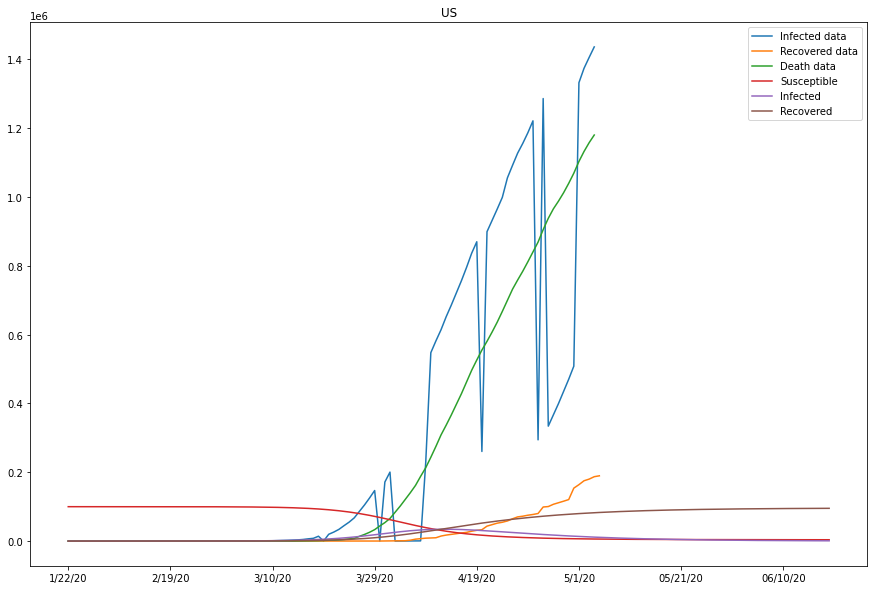

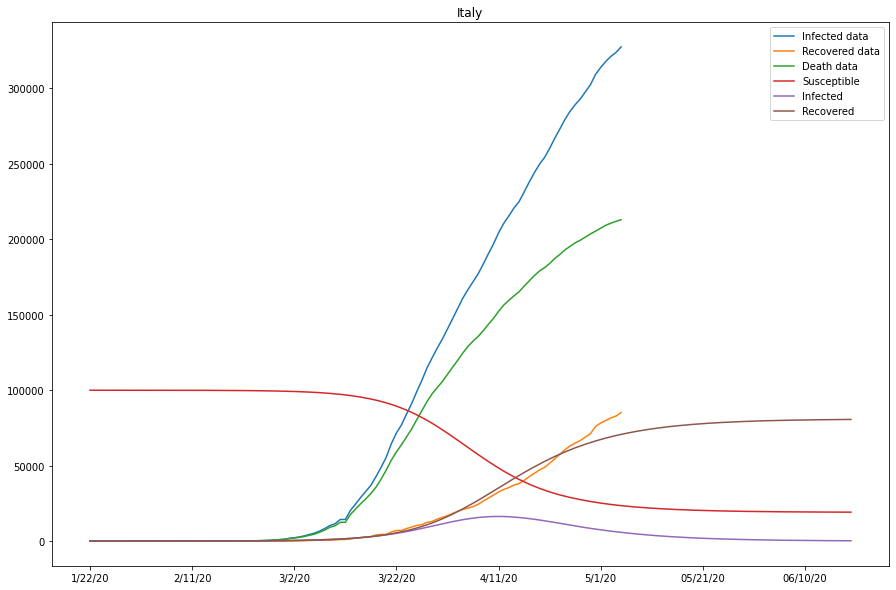

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

link1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
link2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
link3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
link4 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv'

#bring in data
confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
countryCases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv')

#show current situation globally
globalData = countryCases.copy().drop(['Lat', 'Long_', 'Country_Region', 'Last_Update'], axis=1)
globalSum = pd.DataFrame(globalData.sum()).transpose()
globalSum.head()

#draw plot function
color_arr = px.colors.qualitative.Dark24

def draw_plot(ta_array, ta_label, title, colors, mode_size, line_size, x_axis_title, y_axis_title, tickangle=0, yaxis_type=0, additional_annotations=[]):
  fig = go.Figure()
  for index, ta in enumerate(ta_array):
      fig.add_trace(go.Scatter(x=ta.index, y=ta.values, name=ta_label[index], line=dict(color=colors[index], width=line_size[index]), connectgaps=True,))
    
  x_axis_dict = dict(showline=True, showgrid=True, showticklabels=True, linecolor='rgb(204, 204,204)', linewidth=2, ticks='outside', tickfont=dict(family='Arial',size=12,color='rgb(82,82,82)',))

  if x_axis_title:
    x_axis_dict['title'] = x_axis_title

  if tickangle > 0:
    x_axis_dict['tickangle'] = tickangle

  y_axis_dict = dict(showline=True, showgrid=True, showticklabels=True, linecolor='rgb(204, 204,204)', linewidth=2,)

  if yaxis_type != '':
    y_axis_dict['type'] = yaxis_type

  if y_axis_title:
    y_axis_dict['title'] = y_axis_title
  #update layout
  fig.update_layout(xaxis=x_axis_dict, yaxis=y_axis_dict, autosize=True, margin=dict(autoexpand=True, l=100, r=20,t=110,), showlegend=True,)

  annotations = []
  annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05, xanchor='left', yanchor='bottom',text=title, font=dict(family='Arial',size=16,color='rgb(37,37,37)'),showarrow=False))
  
  if len(additional_annotations) > 0:
    annotations.append(additional_annotations)

  # finally update
  fig.update_layout(annotations=annotations)

  return fig

#show confirmed, active, recovered, and deaths for last months
confirmed_ag = confirmed.copy().drop(['Lat', 'Long', 'Country/Region', 'Province/State'], axis=1).sum()
death_ag = deaths.copy().drop(['Lat', 'Long', 'Country/Region', 'Province/State'], axis=1).sum()
recovered_ag = recovered.copy().drop(['Lat', 'Long', 'Country/Region', 'Province/State'], axis=1).sum()
#no time series for active so I had to make it
active_ag = pd.Series(data=np.array([x1 + x2 + x3 for (x1,x2,x3) in zip(confirmed_ag.values,death_ag.values,recovered_ag)]),index=confirmed_ag.index)
displayArray = [confirmed_ag, death_ag, recovered_ag, active_ag]
labels = ['confirmed', 'deaths', 'recovered', 'active']
colors = [color_arr[1], color_arr[2], color_arr[3], color_arr[4]]
mode_size = [8,8,12,8]
line_size = [2,2,4,2]

display = draw_plot(ta_array=displayArray, ta_label=labels, title='Covid Cases', colors=colors, mode_size=mode_size,
                    line_size=line_size, x_axis_title='Date', y_axis_title='Case Count', tickangle=315, yaxis_type="", additional_annotations=[])
display.show()


#############################################################################################
#Use compartmental model to predict future cases for the United States
#model consists of three compartments
# S = number susceptible
# I = number of infectious
# R = number of recovered or deceased individuals

# # data frame for US
# usConfirmed = confirmed[confirmed['Country/Region']=="United States"]
# usConfirmed = usConfirmed.drop(['Lat', 'Long', 'Country/Region', 'Province/State'], axis=1).reset_index(drop=True).sum()

# usDeaths = deaths[deaths['Country/Region']=="United States"]
# usDeaths = usDeaths.drop(['Lat', 'Long', 'Country/Region', 'Province/State'], axis=1).reset_index(drop=True).sum()

# usRecovered = recovered[recovered['Country/Region']=="United States"]
# usRecovered = usRecovered.drop(['Lat', 'Long', 'Country/Region', 'Province/State'], axis=1).reset_index(drop=True).sum()

# activeUS = pd.Series(data=np.array([x1 + x2 + x3 for (x1,x2,x3) in zip(usConfirmed.values,usDeaths.values,usRecovered.values)]),index=usConfirmed)

# train model
# using  solve_ivp from Scipy which solves a system of ordinary differential equations
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from datetime import timedelta, datetime
from matplotlib import pyplot as plt


START_DATE = {'United States': '1/31/20'}

class Learner(object):
  link1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
  link2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
  link3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
  link4 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv'

  def __init__(self, country, loss, start_date='1/22/20', predict_range=150, s_0=100000, i_0=2,r_0=10):
    self.country = country
    self.loss = loss
    self.start_date = start_date
    self.predict_range = predict_range
    self.s_0 = s_0
    self.i_0 = i_0
    self.r_0 = r_0

  def load_confirmed(self, country):
    df = pd.read_csv(link1)
    df = df.drop(['Province/State'], axis=1)
    countryDF = df[df['Country/Region'] == country]
    print(countryDF.head())
    return countryDF.iloc[0].loc[self.start_date:] 

  def load_recovered(self, country):
    df = pd.read_csv(link3)
    df = df.drop(['Province/State'], axis=1)
    countryDF = df[df['Country/Region'] == country]
    print(countryDF.head())
    return countryDF.iloc[0].loc[self.start_date:] 

  def load_dead(self, country):
    df = pd.read_csv(link2)
    df = df.drop(['Province/State'], axis=1)
    countryDF = df[df['Country/Region'] == country]
    print(countryDF.head())
    return countryDF.iloc[0].loc[self.start_date:] 

  def extended_index(self, index, new_size):
    values = index.values
    current = datetime.strptime(index[-1], '%m/%d/%y')
    while len(values) < new_size:
      current = current + timedelta(days=1)
      values = np.append(values, datetime.strftime(current,'%m/%d/%y'))
    return values

  def predict(self, beta, gamma, data, recovered, death, country, s_0, i_0, r_0):
    new_index = self.extended_index(data.index, self.predict_range)
    size = len(new_index)
    def SIR(t,y):
      S = y[0]
      I = y[1]
      R = y[2]
      return [-beta*S*I, beta*S*I-gamma*I, gamma*I]

    extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
    extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
    extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
    return new_index, extended_actual, extended_recovered, extended_death, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0,size,1))


  def train(self):
    recovered = self.load_recovered(self.country)
    death = self.load_dead(self.country)
    data = (self.load_confirmed(self.country) + recovered + death)

    optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, self.s_0, self.i_0, self.r_0), method='L-BFGS-B', bounds=[(0.00000001,0.4), (0.00000001,0.4)])
    
    beta, gamma = optimal.x
    new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(beta, gamma, data, recovered, death, self.country, self.s_0, self.i_0, self.r_0)

    df =  pd.DataFrame({'Infected data':extended_actual, 'Recovered data':extended_recovered, 'Death data': extended_death, 'Susceptible': prediction.y[0], 'Infected': prediction.y[1], 'Recovered': prediction.y[2]}, index=new_index)

    #save predictions to csv
    df.to_csv(f"{self.country}.csv")
    fig, ax = plt.subplots(figsize=(15,10))
    ax.set_title(self.country)
    df.plot(ax=ax)
    print(f"country={self.country}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
    fig.savefig(f"{self.country}.png")
    return df, fig

  #loss function
def loss(point, data, recovered, s_0, i_0, r_0):
  size = len(data)
  beta, gamma = point
  def SIR(t, y):
    S = y[0]
    I = y[1]
    R = y[2]
    return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
  solution = solve_ivp(SIR, [0, size], [s_0, i_0, r_0], t_eval=np.arange(0, size, 1), vectorized=True)
  l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
  l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
  alpha = 0.1
  return alpha * l1 * (1-alpha)*l2

US_learner = Learner(country='US', loss=loss)
US_df, US_fig = US_learner.train()

Italy_learner = Learner(country='Italy', loss=loss)
IT_df, IT_fig = Italy_learner.train()

# This has been a fun and interesting final project with real world practicality.
# I was able to find data through a link that is continuously updates, so it will be interesting to see how my predictions match actual data in the future
# I want to give credit to Jatin Chaudhary who was instrumental in aiding me to complete this project through his video tutorials and blog
# overall my model performs pretty well except deaths seem to have conformed to an exponential line
# this model was done for the United States, but if you do other countries the predicted curves are much more reasonable.
# Since this model is based on exponential growth rates for the US, the model predicts a continuence of these expenetial curves
# but if you do it for Italy or a country that has already reached a peak, the curves have an inflection point in them. 
